<center>
    <h1>
        Term identification system for a specific domain
    </h1>
    Rameez Qurashi, Abdelhak Zabour
    </center>
    

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#
--------Term-identification-system-for-a-specific-domain
----" data-toc-modified-id="
--------Term-identification-system-for-a-specific-domain
-----1"><span class="toc-item-num">1&nbsp;&nbsp;</span>
        Term identification system for a specific domain
    </a></span><ul class="toc-item"><li><span><a href="#Read-the-list-of-terminology" data-toc-modified-id="Read-the-list-of-terminology-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read the list of terminology</a></span></li><li><span><a href="#text-for-training:" data-toc-modified-id="text-for-training:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>text for training:</a></span></li><li><span><a href="#Neural-Network-approach:" data-toc-modified-id="Neural-Network-approach:-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Neural Network approach:</a></span></li><li><span><a href="#Comparison-between-two-approaches" data-toc-modified-id="Comparison-between-two-approaches-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Comparison between two approaches</a></span><ul class="toc-item"><li><span><a href="#test-for-one-file:" data-toc-modified-id="test-for-one-file:-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>test for one file:</a></span></li><li><span><a href="#Test-for-test-corpus:" data-toc-modified-id="Test-for-test-corpus:-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Test for test corpus:</a></span></li></ul></li></ul></li></ul></div>

In [1]:

# import necessary modules

from __future__ import unicode_literals, print_function

from pathlib import Path
from spacy.util import minibatch, compounding
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy import displacy
from collections import Counter
from spacy.matcher import PhraseMatcher
from pprint import pprint
from time import sleep
from progressbar import progressbar
from spacy.tokens import Span
from spacy.util import minibatch, compounding
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import random
import plac
import warnings
import pandas as pd
import numpy as np
import xlrd
import spacy
import os 
import re

plt.rcParams["figure.figsize"] = (15,10)

In [2]:
    
def extract_entities(doc):
    dict_new_ents = {}
    list_new_ents = []
    for ent in doc.ents:
        # Only check
        if ent.label_ == "AstroTerm":
            
            
            list_new_ents.append((ent.start_char, ent.end_char, ent.label_))      
    
    dict_new_ents['entities'] = list_new_ents
            
    return (doc.text,dict_new_ents )


## Read the list of terminology 

In [3]:
terms_corpus = pd.read_excel('astronomy.xls')

In [4]:
# the list containing the pharses to be matched
terminology_list = []
for term in terms_corpus['key']:
    terminology_list.append(term[term.find(':')+2:])

## text for training:

In [5]:
# read the texts from corpus
file = open('corpus/result.txt')
text = file.read()

In [6]:
nlp_rule_based = English()
ruler = EntityRuler(nlp_rule_based)

In [7]:
# create patterns
patterns = []

for term in terminology_list:
    dct = {}
    temp = term.split()
    if len(temp) == 1:
        dct["label"] = "AstroTerm"
        dct["pattern"] = temp[0]
        patterns.append(dct)
    else:
        lst = []
        for item in temp:
            dct_temp = {}
            dct_temp["lower"] = item
            
            lst.append(dct_temp)
            
        dct["label"] = "AstroTerm"
        dct["pattern"] = lst
        patterns.append(dct)

In [8]:
# add patterns and pipe
ruler.add_patterns(patterns)
nlp_rule_based.add_pipe(ruler)

In [9]:
# generate annotated data
train_data = []
for doc in nltk.tokenize.sent_tokenize(text):
    doc = nlp_rule_based(doc)
    train_data.append(extract_entities(doc))

## Neural Network approach:

The neural network approach is already trained using *sequence_tagger.py* file. In this case the training was conducted using an empty model and 50 iterations. For training purposes you can use the mentioned file (instruction are available in readme.txt file).

In [10]:
# upload the saved model
output_dir = "output_dir"
print("Loading from", output_dir)
nlp_seq = spacy.load(output_dir)

Loading from output_dir


## Comparison between two approaches

### test for one file:

In [11]:
# test text
file = open('test_corpus/text02.txt')
text_test = file.read()

In [12]:
# run the neural network model
doc_seq = nlp_seq(text_test)
entities = [(ent.text, ent.label_) for ent in doc_seq.ents]
#print("Entities", entities)
counter_nn = Counter(entities)
counter_nn

Counter({('astrophysicist', 'AstroTerm'): 1,
         ('light', 'AstroTerm'): 2,
         ('observation', 'AstroTerm'): 1,
         ('Spherical Telescope', 'AstroTerm'): 1,
         ('gamma-ray', 'AstroTerm'): 2,
         ('universe', 'AstroTerm'): 4,
         ('neutron', 'AstroTerm'): 2,
         ('polarization', 'AstroTerm'): 4,
         ('Milky Way Galaxy', 'AstroTerm'): 1,
         ('so-called', 'AstroTerm'): 1,
         ('telescope', 'AstroTerm'): 1,
         ('review', 'AstroTerm'): 1,
         ('astronomy', 'AstroTerm'): 1})

In [13]:
# run rule based model
doc = nlp_rule_based(text_test)
entities = [(ent.text, ent.label_) for ent in doc.ents]
#print("Entities", entities)
counter = Counter(entities)
counter

Counter({('astrophysicist', 'AstroTerm'): 1,
         ('light', 'AstroTerm'): 2,
         ('observation', 'AstroTerm'): 1,
         ('gamma-ray', 'AstroTerm'): 2,
         ('universe', 'AstroTerm'): 4,
         ('neutron', 'AstroTerm'): 2,
         ('polarization', 'AstroTerm'): 4,
         ('Milky Way Galaxy', 'AstroTerm'): 1,
         ('so-called', 'AstroTerm'): 1,
         ('telescope', 'AstroTerm'): 1,
         ('review', 'AstroTerm'): 1,
         ('astronomy', 'AstroTerm'): 1})

In [14]:
colors = {"ASTROTERM": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"ents": ["ASTROTERM"], "colors": colors}
doc_seq.user_data["title"] = "Nueral Network Based Model Performance"
displacy.render(doc_seq, style="ent", options=options)

In [15]:
colors = {"ASTROTERM": "linear-gradient(90deg, #f2e441, #ff8730)"}
options = {"ents": ["ASTROTERM"], "colors": colors}
doc.user_data["title"] = "Rule Based Model Performance"
displacy.render(doc, style="ent", options=options, jupyter =True)

In [16]:
# create list for visualization
terms_nn = [[ter, val] for ter, val in zip(counter_nn.keys(),counter_nn.values())]
terms_RB = [[ter, val] for ter, val in zip(counter.keys(),counter.values())]

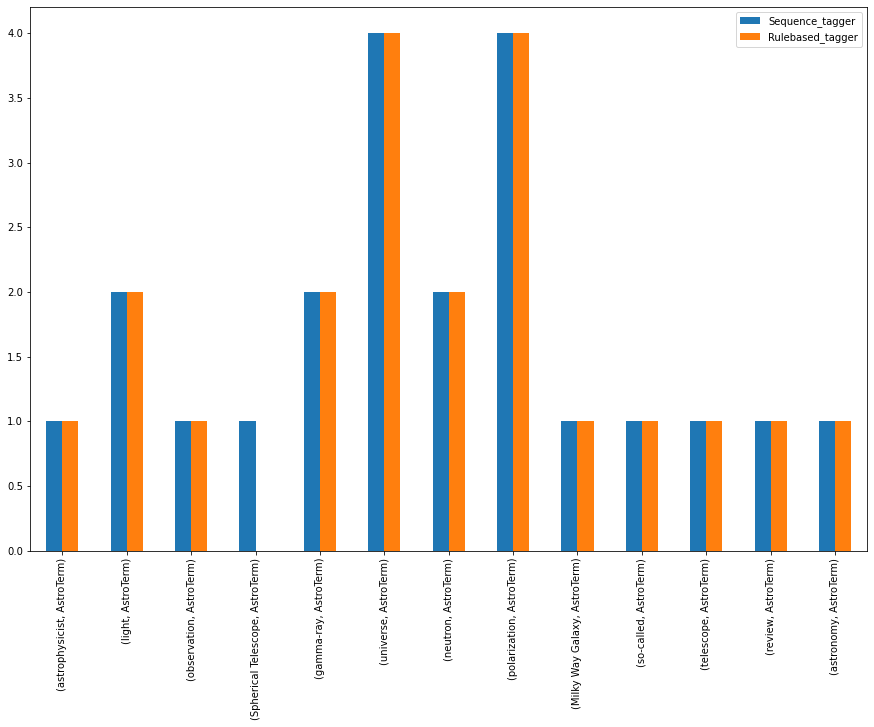

In [17]:
dfs = [pd.DataFrame(np.array(lst), 
                    columns=['idx', i]).set_index('idx')
          for i,lst in zip(['Sequence_tagger', 'Rulebased_tagger'],[terms_nn,terms_RB])]

df = pd.concat(dfs, axis=1)

ax = df.plot.bar()

### Test for test corpus:

In [18]:
def frequency(dir_path):    

    term_fre_seq = []
    term_fre_rb = []
    files = []

    for filename in os.listdir(dir_path):
        file = open(dir_path + filename)
        text_test = file.read()

        # run the neural network model
        doc = nlp_seq(text_test)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        counter_nn = Counter(entities)


        # run rule based model
        doc = nlp_rule_based(text_test)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        counter = Counter(entities)

        fre_nn = sum([val for val in counter_nn.values()])
        fre_rb = sum([val for val in counter.values()])

        term_fre_seq.append(fre_nn)
        term_fre_rb.append(fre_rb)

        files.append(filename)

    return files, term_fre_seq, term_fre_rb
        
    
    

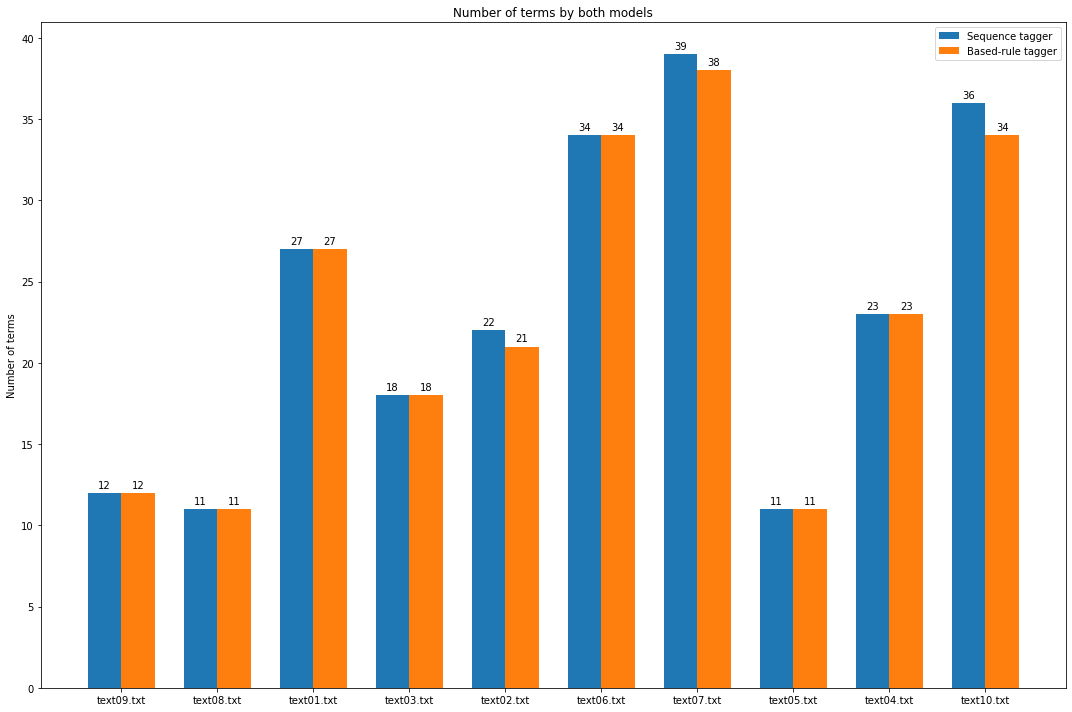

In [19]:
# extract the freqencies of the term by both models
filenames, term_fre_seq, term_fre_rb = frequency("test_corpus/")


x = np.arange(len(filenames))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, term_fre_seq, width, label='Sequence tagger')
rects2 = ax.bar(x + width/2, term_fre_rb, width, label='Based-rule tagger')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of terms')
ax.set_title('Number of terms by both models')
ax.set_xticks(x)
ax.set_xticklabels(filenames)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [20]:
print('Ratio between tagged terms by sequence model and rule-based model: ', sum(term_fre_seq)/sum(term_fre_rb))

Ratio between tagged terms by sequence model and rule-based model:  1.017467248908297
